# Data Explorer via XAI

This tutorial demonstrats how to explorer different types of data using `xai.data.explorer`. 

We have supported the following types of data:
 - Categorical
 - Numerical
 - Free Text
 - Datetime

In [1]:
# Some auxiliary imports for the tutorial
import sys
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import datasets
import matplotlib.pyplot as plt
sys.path.append('../../')
import xai

We use the following datasets as samples to demonstrate the above analyzers:
 - [Breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer): demonstration for `xai.data.explorer.categorical`
 - [Iris plants dataset](https://scikit-learn.org/stable/datasets/index.html#iris-plants-dataset): demonstration for `xai.data.explorer.numerical`
 - [The 20 newsgroups text dataset](https://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset): demonstration for `xai.data.explorer.text`
 - Self-generated dataset: demonstration for `xai.data.explorer.datetime`

## 1. Categorical
Package `xai.data.explorer.categorical` analyzes categorical datasets and produces a frequency count for each categorical value. `categorical_analyzer` can feed in categorical values and return a `categorical_stats` object, which contains frequency count for each unique value. `labelled_categorical_analyzer` takes an additional argument *class* when fed values, and it generates frequency counts by class type.

In [2]:
# load dataset
cols_names = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 
              'deg-malig', 'breast', 'breast-quad', 'irradiat']
# read the data
breast_data = pd.read_csv('sample_data/breast-cancer.data', header=None, 
                 names=cols_names).replace({'?': 'unknown'})  # NaN are represented by '?'

breast_data.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [3]:
from xai.data.explorer.categorical.labelled_categorical_analyzer import LabelledCategoricalDataAnalyzer

We define a helper function `plot_labelled_categorical_stats` to help visualize generated statistics.

In [4]:
def plot_labelled_categorical_stats(labelled_stats, all_stats, label_column, feature_column):
    x = list(all_stats.frequency_count.keys())
    counter = Counter({label:0 for label in x})
    legends = []
    plots = []
    
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    for _class, _stats in labelled_stats.items():
        frequency = _stats.frequency_count
        bottom = [dict(counter)[key] for key in x]
        height = [frequency[key] for key in x]
        p = plt.bar(height=height, x=x, bottom=bottom)
        counter.update(Counter(frequency))
        legends.append(_class)
        plots.append(p)
    plt.legend(plots,legends)
    plt.title('Distribution: %s - %s'%(label_column,feature_column))
    plt.xlabel(feature_column)
    
    plt.subplot(122)
    plt.bar(height=all_stats.frequency_count.values(), x=all_stats.frequency_count.keys())
    plt.title('All Distribution')
    plt.xlabel(feature_column)
    plt.show()

First, we analyze *breast-quad* column based on *Class*. The frequency count for each breast-quad is summarized per class type, as shown in the figure on the left. `labelled_categorical_analyzer` also generates a combined frequency counts across all classes, as shown in the figure on the right.

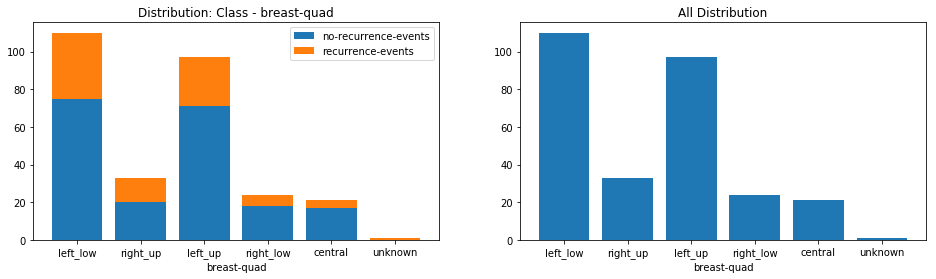

In [5]:
label_column = 'Class'
feature_column = 'breast-quad'
labelled_analyzer = LabelledCategoricalDataAnalyzer()
labelled_analyzer.feed_all(breast_data[feature_column].tolist(),breast_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics()
plot_labelled_categorical_stats(labelled_stats, all_stats, label_column, feature_column)

Similarly, we can analyze *breast-quad* column but choose *menopause* as class. The frequency count for each breast-quad is summarized per menopause type.

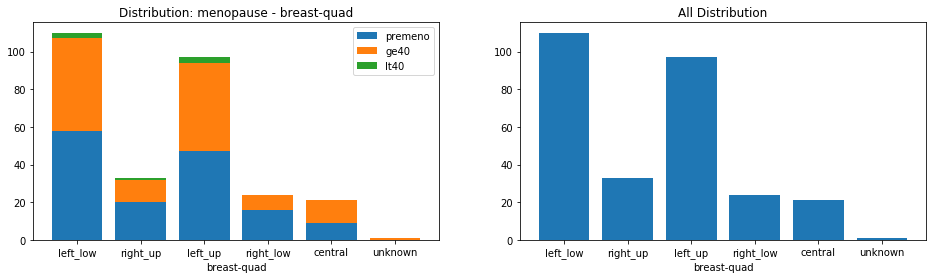

In [6]:
label_column = 'menopause'
feature_column = 'breast-quad'
labelled_analyzer = LabelledCategoricalDataAnalyzer()
labelled_analyzer.feed_all(breast_data[feature_column].tolist(),breast_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics()
plot_labelled_categorical_stats(labelled_stats, all_stats, label_column, feature_column)

## 2. Numerical

Package `xai.data.explorer.numerical` analyzes numerical datasets and produces statistics analysis including *min*, *max*, *mean*, *median*, *sd*, *histogram* and *kde*. `numerical_analyzer` takes all inputted numerical values and generates an overall analysis, while `labelled_numerical_analyzer` takes numerical values and class labels to generate analysis per class type.

In [7]:
# load dataset
iris = datasets.load_iris()
iris_data = pd.DataFrame(iris.data,columns=iris.feature_names)
iris_data['Class'] = iris.target
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
from xai.data.explorer.numerical.labelled_numerical_analyzer import LabelledNumericalDataAnalyzer

We define a helper function `plot_labelled_numerical_stats` to help visualize generated statistics.

In [9]:
def plot_labelled_numerical_stats(labelled_stats, all_stats, label_column, feature_column):
    labelled_stats_table = []
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    legends = []
    plots = []
    for _class, _stats in labelled_stats.items():
        hist = _stats.histogram
        kde = np.array([[x,y] for (x,y) in _stats.kde])
        x = [i[0] for i in hist]
        w = [(i[1]-i[0]) for i in hist]
        h = [i[2] for i in hist]
        x_ticks = ["%.2f-%.2f"%(i[0],i[1]) for i in hist[1:-1]]
        x_tick_locs = [(i[0]+i[1])*0.5 for i in hist[1:-1]]
        p = plt.bar(x=x, height=h, width=w, align='edge',alpha=0.4)
        legends.append(_class)
        plots.append(p)
        labelled_stats_table.append({'class':_class,'min':_stats.min, 'max':_stats.max, 'mean':_stats.mean,'median':_stats.sd, 'sd':_stats.max, 'total_count':_stats.total_count})
    plt.legend(plots,legends)
    plt.title('Distribution: %s - %s'%(label_column,feature_column))
    plt.xlabel(feature_column)

    plt.subplot(132)
    hist = all_stats.histogram
    x = [i[0] for i in hist]
    w = [(i[1]-i[0])*0.9 for i in hist]
    h = [i[2] for i in hist]
    x_ticks = ["%.2f-%.2f"%(i[0],i[1]) for i in hist]
    x_tick_locs = [(i[0]+i[1])*0.5 for i in hist]
    plt.bar(x=x, height=h, width=w, align='edge',alpha=0.8)
    plt.xticks(x_tick_locs,x_ticks, rotation=45)
    plt.title('All Distribution')
    plt.xlabel(feature_column)
    labelled_stats_table.append({'class':'all','min':all_stats.min, 'max':all_stats.max, 'mean':all_stats.mean,'median':all_stats.sd, 'sd':all_stats.max, 'total_count':all_stats.total_count})

    plt.subplot(133)
    legends = []
    plots = []
    for _class, _stats in labelled_stats.items():
        kde = np.array([[x,y] for (x,y) in _stats.kde])
        plt.plot(kde[:,0],kde[:,1])
        legends.append(_class)
        plots.append(p)
    plt.xlabel(feature_column)

    kde = np.array([[x,y] for (x,y) in all_stats.kde])
    plt.plot(kde[:,0],kde[:,1],'--')
    legends.append('all')
    plt.legend(legends)
    plt.title('KDE: %s - %s'%(label_column,feature_column))
    
    plt.show()
    
    _stats_df = pd.DataFrame.from_records(labelled_stats_table)
    return _stats_df

First, we show statistics of *sepal width (cm)* with respect to *Class*.

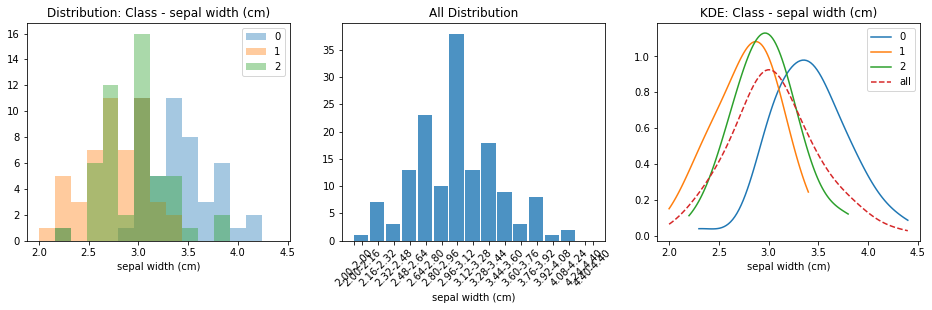

,class,max,mean,median,min,sd,total_count
0,0,4.4,3.418,0.377195,2.3,4.4,50
1,1,3.4,2.770,0.310644,2.0,3.4,50
2,2,3.8,2.974,0.319255,2.2,3.8,50
3,all,4.4,3.054,0.432147,2.0,4.4,150


In [10]:
label_column = 'Class'
feature_column = 'sepal width (cm)'
labelled_analyzer = LabelledNumericalDataAnalyzer()
labelled_analyzer.feed_all(iris_data[feature_column].tolist(),iris_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics(extreme_value_percentile=[0,100],num_of_bins=15)
_stats_df = plot_labelled_numerical_stats(labelled_stats, all_stats, label_column, feature_column)
_stats_df.head()

Here is another example of statistics of *petal length (cm)* with respect to *Class*.

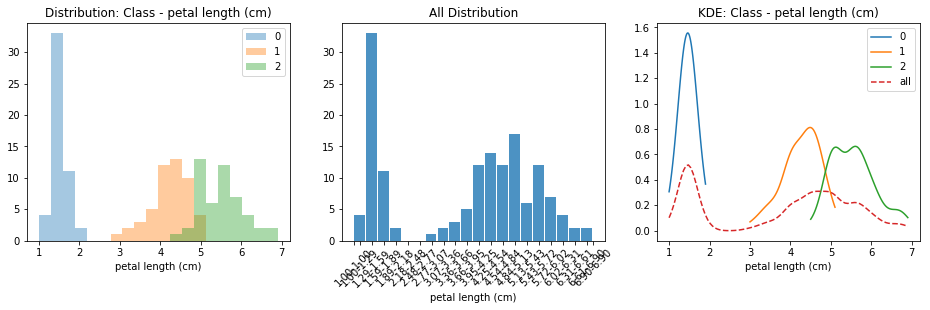

,class,max,mean,median,min,sd,total_count
0,0,1.9,1.464000,0.171767,1.0,1.9,50
1,1,5.1,4.260000,0.465188,3.0,5.1,50
2,2,6.9,5.552000,0.546348,4.5,6.9,50
3,all,6.9,3.758667,1.758529,1.0,6.9,150


In [11]:
label_column = 'Class'
feature_column = 'petal length (cm)'
labelled_analyzer = LabelledNumericalDataAnalyzer()
labelled_analyzer.feed_all(iris_data[feature_column].tolist(),iris_data[label_column].tolist())
labelled_stats, all_stats = labelled_analyzer.get_statistics(extreme_value_percentile=[0,100],num_of_bins=20)
plot_labelled_numerical_stats(labelled_stats, all_stats, label_column, feature_column)

## 3. Text

Package `xai.data.explorer.text` analyzes free text datasets and produces statistics analysis including *word count*, *character count*, *term frequency*, *document frequency* and *tfidf*. `text_analyzer` takes all inputted free text and generates an overall analysis, while `labelled_text_analyzer` takes free text and associated class labels to generate statistical analysis per class type.

In [12]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
sample_num = 2000
texts = data['data'][:sample_num]
labels = [data['target_names'][i] for i in data['target']][:sample_num]

In [13]:
from xai.data.explorer.text.labelled_text_analyzer import LabelledTextDataAnalyzer

def preprocess(text):
    import re
    text = re.sub(r'[^\w\s]',' ',text)
    return text

predefined_pattern = {'point':r'p\d','number':r'\d+','singlar':r'\s\w\s'}

We define a helper function `plot_labelled_text_stats` to help visualize generated statistics.

In [14]:
def plot_labelled_text_stats(labelled_stats, all_stats):
    import operator
    labelled_stats_table = []
    
    for _class in list(labelled_stats.keys())[:5]:
        record = {'class':_class}
        _stats = labelled_stats[_class]
        record['total count'] = _stats.total_count
        plt.figure(figsize=(16,4))
        plt.subplot(121)
        tfidf = sorted(_stats.tfidf.items(), key=operator.itemgetter(1),reverse=True)[:20]
        words = [item[0] for item in tfidf][::-1]
        scores = [item[1] for item in tfidf][::-1]
        plt.barh(width=scores, y=words)
        plt.title('Average TFIDF\nclass:%s'%_class)
        plt.subplot(122)
        tf = sorted(_stats.term_frequency.items(), key=operator.itemgetter(1),reverse=True)[:20]
        words = [item[0] for item in tf][::-1]
        count = [item[1] for item in tf][::-1]
        plt.barh(width=count, y=words)
        plt.title('Overall Term Frequency\nclass: %s'%_class)
        for pattern, count in _stats.pattern_stats.items():
            record['%s (term count)'%pattern] = count[0]
            record['%s (doc count)'%pattern] = count[1]
        record['longest doc'] = max(list(_stats.word_count.keys()))
        labelled_stats_table.append(record)
        
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    tfidf = sorted(all_stats.tfidf.items(), key=operator.itemgetter(1),reverse=True)[:20]
    words = [item[0] for item in tfidf][::-1]
    scores = [item[1] for item in tfidf][::-1]
    plt.barh(width=scores, y=words)
    plt.title('Average TFIDF\nall class')
    plt.subplot(122)
    tf = sorted(all_stats.term_frequency.items(), key=operator.itemgetter(1),reverse=True)[:20]
    words = [item[0] for item in tf][::-1]
    count = [item[1] for item in tf][::-1]
    plt.barh(width=count, y=words)
    plt.title('Overall Term Frequency\nall class')
    plt.show()
    record = {'class':'all'}
    record['total count'] = all_stats.total_count
    for pattern, count in all_stats.pattern_stats.items():
        record['%s (term count)'%pattern] = count[0]
        record['%s (doc count)'%pattern] = count[1]
    record['longest doc'] = max(list(all_stats.word_count.keys()))
    labelled_stats_table.append(record)

    _stats_df = pd.DataFrame.from_records(labelled_stats_table)
    return _stats_df
    

First, we show tfidf and term frequency by class type. Then we show tfidf and term frequency across all classes. 

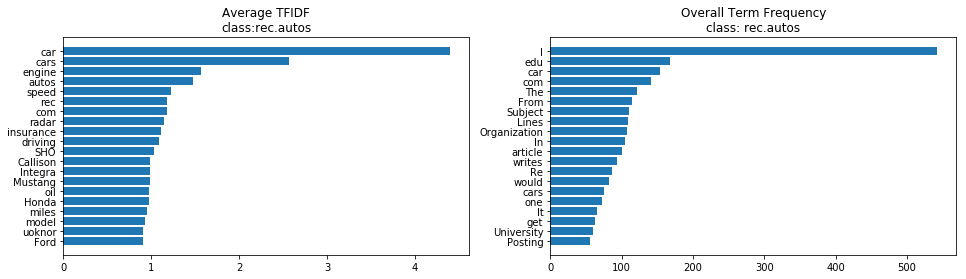

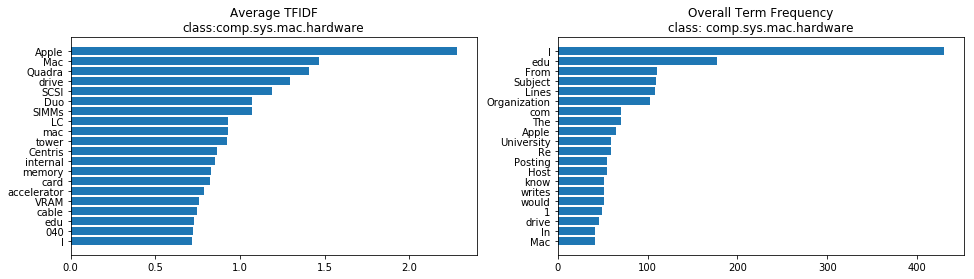

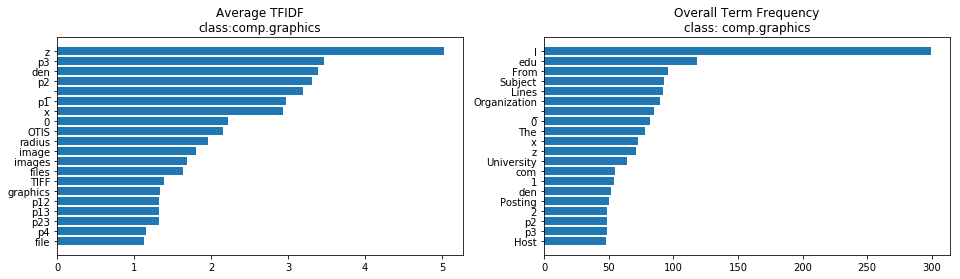

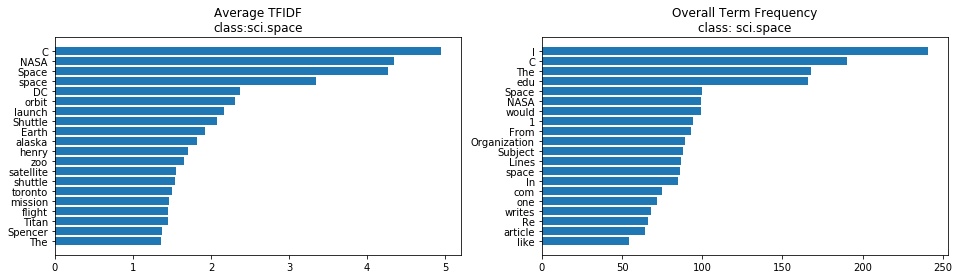

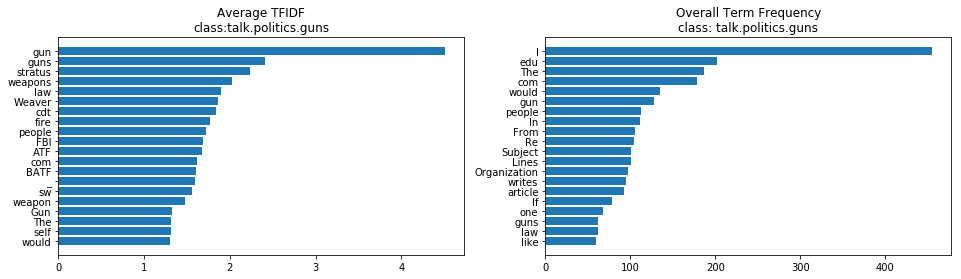

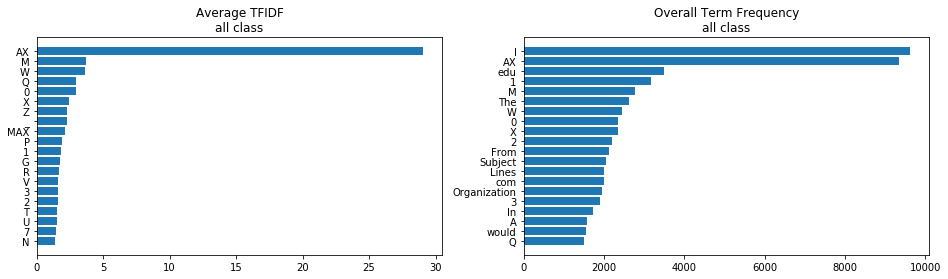

,class,longest doc,number (doc count),number (term count),point (doc count),point (term count),singlar (doc count),singlar (term count),total count
0,rec.autos,1963,109,1748,2,2,109,2019,109
1,comp.sys.mac.hardware,566,108,1132,4,5,108,1324,108
2,comp.graphics,1595,92,1277,4,207,92,1632,92
3,sci.space,3782,87,1799,0,0,87,1794,87
4,talk.politics.guns,2552,100,1022,4,4,100,1924,100
5,all,15769,2000,69203,46,264,1997,62943,2000


In [16]:
labelled_analyzer = LabelledTextDataAnalyzer(preprocess_fn=preprocess,stop_words_by_languages=['english'],
                                             predefined_pattern=predefined_pattern)
labelled_analyzer.feed_all(texts,labels)
labelled_stats, all_stats = labelled_analyzer.get_statistics()
_stats_df = plot_labelled_text_stats(labelled_stats, all_stats)
_stats_df

## 4. Datetime

Package `xai.data.explorer.datetime` analyzes date time datasets and produces frequency counts for a given resolution, which can be *year*, *month*, *day*, *weekday*, *hour*, *minute*, or *second*. `datetime_analyzer` takes all values and generates an overall analysis, while `labelled_datetime_analyzer` generates statistical analysis per class type.

In [17]:
filename = 'sample_data/date.csv'
data = pd.read_csv(filename)
data.head()


,COMPANYCODE,POSTINGDATE,VALUEDATE
0,13,20180309,20180309
1,13,20180223,20180223
2,13,20180223,20180223
3,13,20180223,20180223
4,13,20180227,20180227


In [18]:
from xai.data.explorer.datetime.labelled_datetime_analyzer import LabelledDatetimeDataAnalyzer
from xai.data.constants import DatetimeResolution

We set the resolution to be *year* and *month*, so that input data will be grouped by their year and month.

In [19]:
datetimes = [int(x) for x in data['POSTINGDATE']]
labels =[int(x) for x in data['COMPANYCODE']]

labelled_analyzer = LabelledDatetimeDataAnalyzer()
labelled_analyzer.feed_all(datetimes,labels)
labelled_stats, all_stats = labelled_analyzer.get_statistics(resolution_list=[DatetimeResolution.YEAR,
                                                                               DatetimeResolution.MONTH])

We define a helper function `plot_labelled_datetime_stats` to help visualize generated statistics.

In [20]:
def plot_labelled_datetime_stats(labelled_stats, all_stats, label_name):     
    def _plot(_class,_frequency_count):
        plt.figure(figsize=(8,4))
        data_dist = {k: v for (k, v) in sorted(_frequency_count.items())}
        min_year = list(data_dist.keys())[0]
        max_year = list(data_dist.keys())[-1]

        earliest = (min_year, min([int(month) for month in data_dist[min_year].keys()]))
        latest = (max_year, max([int(month) for month in data_dist[max_year].keys()]))

        line_num = len(data_dist)
        data_frame = []
        for year in data_dist:
            year_data = [0] * 13
            year_data[0] = year
            for month in data_dist[year]:
                year_data[int(month)] = int(data_dist[year][month])
            data_frame.append(year_data)
        data_frame = np.array(data_frame).astype(int)
        bars = []
        colors = ['#1abc9c', '#2ecc71', '#3498db', '#7f8c8d', '#9b59b6', '#34495e', '#f1c40f', '#e67e22', '#e74c3c',
                  '#95a5a6', '#d35400', '#bdc3c7']
        legends = ['Jan', 'Feb', 'Mar', 'April', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        current_sum = np.zeros(line_num)
        for month in range(1, 13):
            p = plt.barh(y=list(range(0, line_num)), width=data_frame[:, month].tolist(), left=current_sum.tolist(),
                         color=colors[month - 1])
            bars.append(p)
            current_sum = data_frame[:, month] + current_sum
        for idx in range(line_num):
            plt.text(current_sum[idx], idx, int(current_sum[idx]), color='black', ha="left")

        plt.yticks(list(range(0, line_num)), list(data_dist.keys()))
        plt.legend(bars, legends, bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.title(
            '%s - %s\nDate Range: %s.%s - %s.%s' % (label_name,_class,earliest[0], legends[earliest[1] - 1], latest[0], legends[latest[1] - 1]))
        plt.show()
    
    for _class in list(labelled_stats.keys())[:3]:
        _plot(_class,labelled_stats[_class].frequency_count)
        
    _plot('all',all_stats.frequency_count)

The figures below show frequency counts by class based on *year* and *month* as configured previsouly.

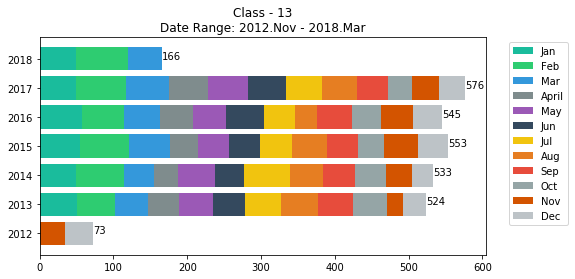

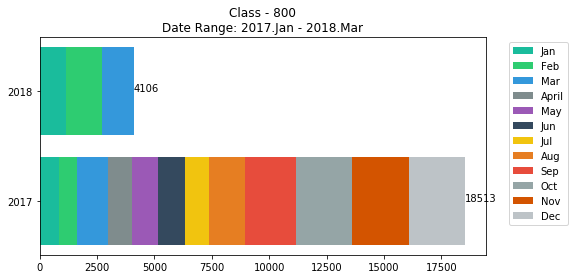

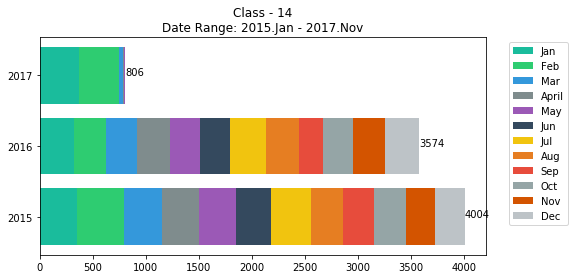

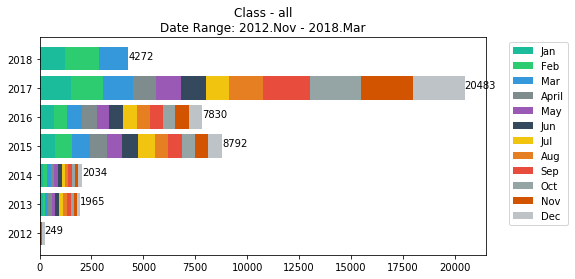

In [21]:
plot_labelled_datetime_stats(labelled_stats, all_stats, label_column)